## Project 1 - Part 2

## <em> Optimization, Markov chain Monte Carlo, Bayesfast </em>
<br>
This notebook is arranged in cells. Texts are usually written in the markdown cells, and here you can use html tags (make it bold, italic, colored, etc). You can double click on this cell to see the formatting.<br>
<br>
The ellipsis (...) are provided where you are expected to write your solution but feel free to change the template (not over much) in case this style is not to your taste. <br>
<br>
<em>Hit "Shift-Enter" on a code cell to evaluate it.  Double click a Markdown cell to edit. </em><br>

<span style="color:blue"><i> Partner: Faizan Samad </i></span> <br>

***
### Link Okpy

In [1]:
from client.api.notebook import Notebook
ok = Notebook('project1_p2_188.ok')
_ = ok.auth(inline = True)

Assignment: Project 1 Part 2
OK, version v1.12.5

Successfully logged in as chancetran@berkeley.edu


### Imports

In [2]:
import numpy as np
from scipy.integrate import quad
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline

***

#### Problem 1 - Planck analysis continued - Nonlinear (Quadratic) Model


In Project 1 - part 1, we assumed a simple linear model of the theory CMB power spectrum with 6 cosmological parameters, $[\Omega_b h^2, \Omega_c h^2, H_0, \tau, A_s, n_s]$, and found the best-fit model using linear algebra and Gauss-Newton method, but optimization was rather trivial with the given linear model. In Part 2, we add quadratic terms to our model of the CMB power spectrum with 2 additional parameters: $\Omega_k$ (curvature density parameter) and $y_{\\ cal}$ (Planck survey calibration parameter). We also replace $H_0$ with $100\theta_{MC}$ (a measure of the sound horizon at last scattering), which can be converted into $H_0$.

In summary, we take a <span style="color:blue">quadratic</span> model of the CMB power spectrum with the following 8 paramters: <span style="color:blue">$$[\Omega_b h^2, \Omega_c h^2, 100\theta_{MC}, \tau, \Omega_K, {\rm{ln}}(10^{10} A_s), n_s, y_{\rm cal}]$$</span>


In [3]:
import sys; sys.path.append('/srv/app/venv/assignment-1910')
from cosmofast.planck2018._simall import _simall_f, _simall_j, _simall_fj
from cosmofast.planck2018._plik_lite_diag import _plik_lite_f, _plik_lite_j, _plik_lite_fj, _get_binned_cls
from cosmofast.planck2018._commander import _commander_f, _commander_j, _commander_fj
import dill
dill.settings['recurse'] = True
  
import os
os.environ['OMP_NUM_THREADS'] = '1'

From the Planck measurements, we take 28 unbinned TT power spectrum for $2 \leq \ell < 30$, 28 unbinned EE power spectrum for $2 \leq \ell < 30$, and 215 binned TT power spectrum for $30 \leq \ell < 2500$ - total of 271 data points.

Our quadratic model defined below ("quadmodel") can evaluate the power spectrum in the above 271 $\ell$ bins, given 7 cosmological parameters ($\Omega_b h^2, \Omega_c h^2, 100\theta_{MC}, \tau, \Omega_K, {\rm{ln}}(10^{10} A_s), n_s$) - note that the calibration parameter is excluded.

Suppose that our initial guess of the 8 model parameter is:
$$ \textbf{x0} = [\Omega_b h^2, \Omega_c h^2, 100\theta_{MC}, \tau, \Omega_K, {\rm{ln}}(10^{10} A_s), n_s, y_{\rm cal}] = [ 0.022,  0.10 ,  1.  ,  0.08, 0., 3.  ,  0.958 ,  1. ].$$ 

In [4]:
# Load the quadratic model for Planck 2018 Omega_K lilelihood
# Note that we do linear extrapolation outside the sample range
with open('/srv/app/venv/assignment-1910/data/den2.p', 'rb') as f:
    quadmodel = dill.load(f)

In [5]:
x0 = np.array([ 0.022,  0.10 ,  1.  ,  0.08, 0., 3.  ,  0.958 ,  1. ])

Then, given our initial guess x0, we can evaluate model power spectra in the following way:

In [6]:
quadModel_naive = quadmodel._module_list[0](x0[:7])

You see that it outputs the power spectra in 271 $\ell$ bins.

Note that 215 high-$\ell$ ($\ell > 30)$ TT power spectrum from the model (the last 215 entries) is also diagonalized (multiplied by the cholesky of the likelihood covariance) so that the likelihood is simply -0.5*(data-model)^2.

Now let's compare this diagonalized high-$\ell$ TT power spectrum to the measured data. 

In [7]:
# Load measured data
Y = np.loadtxt('data_Planck.dat')
ell = Y[0,:]
measured = Y[1,:]

"ell" is the effective $\ell$ values in 215 $\ell$ bins, and "measured" is the corresponding measured TT power spectra.
<br><br>
<span style="color:blue"> <i> 1. Show how well the high-$\ell$ TT model power spectra (given our initial guess x0) fits the data. i.e. Plot a "scatterplot" of the measured data (use '.' marker) and the high-$\ell$ TT model power spectra (use a dotted line '--') in one figure. </i></span><br>


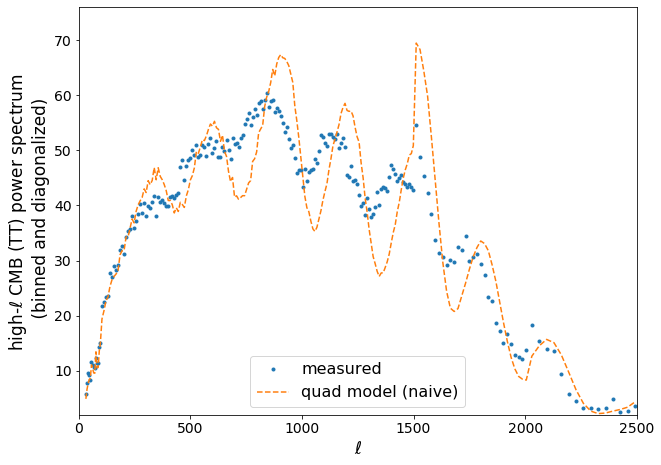

In [8]:
# Plotting.
plt.figure(figsize = (10, 7.5))

plt.plot(ell, measured, label = 'measured', linestyle = '', marker = '.')
plt.plot(ell, quadModel_naive[quadModel_naive.size - ell.size:], label = 'quad model (naive)', linestyle = '--')

plt.xlim(( 0, 2500))
plt.ylim((2, 76))
plt.xticks([0, 500, 1000, 1500, 2000, 2500],[0, 500, 1000, 1500, 2000, 2500], fontsize = 14)
plt.yticks([10, 20, 30, 40, 50, 60, 70],[10, 20, 30, 40, 50, 60, 70], fontsize = 14)
plt.legend(fontsize = 16)
plt.xlabel('$\ell$', fontsize = 17)
plt.ylabel('high-$\ell$ CMB (TT) power spectrum \n (binned and diagonalized)', fontsize = 17)
plt.show()

Next, let's try the <b>maximum a posteriori estimation (MAP)</b>. 

**quadmodel(x0)** outputs the log-posterior (logp) distribution. To get the MAP estimate, we should maximize logp (i.e. (data-model) is minimized). Then, we need graident and hessian of -logp.

Given x0, we can evaluate the gradient of -logp:

&nbsp; **-quadmodel.grad(x0)**

The hessian of -logp given x0 is:

&nbsp; **Hessian(lambda xx: -quadmodel(xx), 1e-4)(x0)**

Note that "-quadmodel.grad" and "Hessian(lambda xx: -quadmodel(xx), 1e-4)" are functions, and you can evaluate them with different model parameter values.

Now, let us use scipy.optimize.minimize (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to get the MAP estimate of the model parameters: we can minimize -logp to get the MAP estimate. 

<span style="color:blue"> <i> 2. Using the Newton conjugate gradient method ('Newton-CG'), find the MAP estimate of 8 model parameters with scipy.optimize.minimize. Print MAP estimates of the 8 model parameters. </i></span><br>

Hint: you can do

opt_NCG = minimize(**"1.-logp function"**, **2.initial guess (x0 in this case)**, method='Newton-CG', jac=**3.function for gradient of -logp**, hess=**4.function for gradient of -logp**, options={'return_all': True, 'disp': True})

After optimization terminated successfully, you can retrieve the best-fit parameters with:

&nbsp; **opt_NCG.x**

In [9]:
from scipy.optimize import minimize
from hessian import Hessian

In [10]:
opt_NCG = minimize(lambda xx: -quadmodel(xx), x0, 
                   method = 'Newton-CG',
                   jac = lambda xx: -quadmodel.grad(xx),
                   hess = Hessian(lambda xx: -quadmodel(xx), 1e-4),
                   options = {'return_all': True, 'disp': True})

Optimization terminated successfully.
         Current function value: 302.831104
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13


In [11]:
# The computed parameters using minimize().
x0_NCG = opt_NCG.x

labels =  ['\\Omega_b h^2', '\\Omega_c h^2', '100\\theta_{MC}', '\\tau', 
           '\Omega_K', '{\\rm{ln}}(10^{10} A_s)', 'n_s', 'y_{\\rm cal}']

for i in range(len(labels)):
    print("MAP value of %s = %.5f" %(labels[i], x0_NCG[i]))

MAP value of \Omega_b h^2 = 0.02252
MAP value of \Omega_c h^2 = 0.11766
MAP value of 100\theta_{MC} = 1.04120
MAP value of \tau = 0.04899
MAP value of \Omega_K = -0.05048
MAP value of {\rm{ln}}(10^{10} A_s) = 3.02766
MAP value of n_s = 0.97079
MAP value of y_{\rm cal} = 0.99996



<span style="color:blue"> <i> 3. Repeat Part 1 with the best-fit model you have found in Part 2. </i></span><br>


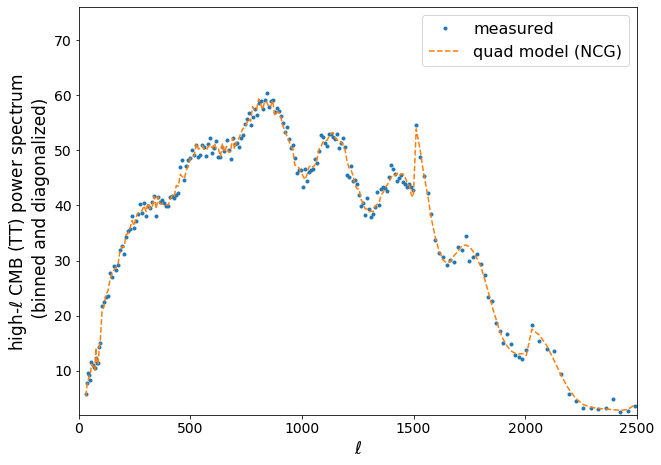

In [12]:
# Power spectrum from the model.
quadModel_NCG = quadmodel._module_list[0](x0_NCG[:7])

# Plotting.
plt.figure(figsize = (10, 7.5))

plt.plot(ell, measured, label = 'measured', linestyle = '', marker = '.')
plt.plot(ell, quadModel_NCG[quadModel_NCG.size - ell.size:], label = 'quad model (NCG)', linestyle = '--')

plt.xlim(( 0, 2500))
plt.ylim((2, 76))
plt.xticks([0, 500, 1000, 1500, 2000, 2500],[0, 500, 1000, 1500, 2000, 2500], fontsize = 14)
plt.yticks([10, 20, 30, 40, 50, 60, 70],[10, 20, 30, 40, 50, 60, 70], fontsize = 14)
plt.legend(fontsize = 16)
plt.xlabel('$\ell$', fontsize = 17)
plt.ylabel('high-$\ell$ CMB (TT) power spectrum \n (binned and diagonalized)', fontsize = 17)
plt.show()

Run below cells to create an animation which shows how the model spectrum fits better with the measured data as we iterate in the optimization process.

In [13]:
from matplotlib import animation, rc
from IPython.display import HTML

In [14]:
%%capture
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(10, 7), edgecolor='black')
rc('axes', linewidth=1.1)


ax.set_xlim(( 0, 2500))
ax.set_ylim((2, 76))
ax.set_xticks([0, 500, 1000, 1500, 2000, 2500])
ax.set_xticklabels([0, 500, 1000, 1500, 2000, 2500], fontsize = 14)

ax.set_yticks([10, 20, 30, 40, 50, 60, 70])
ax.set_yticklabels([10, 20, 30, 40, 50, 60, 70], fontsize = 14)

ax.set_xlabel('$\ell$', fontsize = 17)
ax.set_ylabel('high-$\ell$ CMB (TT) power spectrum \n (binned and diagonalized)', fontsize = 17)


ax.plot(ell, measured, '.', label = 'data')
ax.set_facecolor('whitesmoke')
ax.grid(linestyle='--', linewidth='0.5', color='grey')
line, = ax.plot([], [], lw=2, label = 'model (fit)')

#initialization function: plot the background of each frame
def init():
    line, = ax.plot([], [], lw=2)
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    y = quadmodel._module_list[0](opt_NCG.allvecs[i][:7])[56:]
    line.set_data(ell, y)
    ax.text(200, 70, 'iteration = %d' %i, color='black',fontsize = 22,
        bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 4.2, 'edgecolor': 'white'})
    return (line,)

ax.legend(fontsize = 16)


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=opt_NCG.nit, interval=500, blit=True, repeat=False)


In [15]:
HTML(anim.to_jshtml())


Markov chain Monte Carlo is a general method based on drawing values of $\theta$ from approximate distributions and then correcting those draws to better aproximate the target posterior distribution. The sampling is done sequentially, wtih the distribution of the sampled draws depending on the last value drawn - hence, the draws from a Markov chain. (p. 275, <i>Bayesian Data Analysis</i>, Andrew Gelman et al.) (Remember that a sequence $x_1, x_2, ...$ of random events is called a Markov chain if $x_{n+1}$ depends explicitly on $x_{n}$ only (and not explicitly on previous steps).) Here, we consider our 8 model paramters, so the "chain" in this case is a random walk through the parameter space.
<br>
![alt text](MCMC.png "Title")
from https://github.com/KIPAC/StatisticalMethods/blob/master/chunks/montecarlo1.ipynb
<br><br>
As shown in the above figure, chains take time to converge to the target distribution, and you can determine the "burn-in" period, the number of sequences it takes to reach convergence.
<br><br>
In Part 4, we provide you MCMC chains from Planck. You can plot the chains in the parameter space and estimate the posterior distribution.
<br><br>
<i>References:</i><br>
Bayesian Data Analysis, Andrew Gelman et al.

Now, we provide you with 4 independent Planck MCMC chains. For each chain, we load the data for 8 model parameters, $[\Omega_b h^2, \Omega_c h^2, 100\theta_{MC}, \tau, \Omega_K, {\rm{ln}}(10^{10} A_s), n_s, y_{\rm cal}]$.

In [16]:
# These are the official Planck chains
x_mcmc = np.concatenate((
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_1.txt')[:,2:10][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_2.txt')[:,2:10][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_3.txt')[:,2:10][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_4.txt')[:,2:10][:3724]))
p_mcmc = np.concatenate((
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_1.txt')[:,0][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_2.txt')[:,0][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_3.txt')[:,0][:3724],
    np.loadtxt('/srv/app/venv/assignment-1910/data/base_omegak_plikHM_TT_lowl_lowE_4.txt')[:,0][:3724]))

In [17]:
from getdist import plots, MCSamples

Here, we use MCSamples from **getdist** package (https://getdist.readthedocs.io/en/latest/mcsamples.html) to create a class of MCMC samples. 

&nbsp; **MCMC = MCSamples(samples=x_mcmc, weights=p_mcmc)**

To get actual samples from this class, we can do:

&nbsp; **MCMC_samples = MCMC.samples**

We reshape this in the following way:

&nbsp; **MCMC_samples = MCMC_samples.reshape(# of samples per chain, # of chains, # of parameters)**


In [18]:
names = ["x%s" % i for i in range(8)]
MCMC = MCSamples(samples=x_mcmc, weights=p_mcmc, names=names, labels=labels)
MCMC_samples = MCMC.samples
MCMC_samples = MCMC_samples.reshape(3724,4,8)

Removed no burn in


In MCMC, we need to make sure that chains converge to the posterior distribution. One useful test for convergence is "Gelman-Rubin statistic." For a given parameter, $\theta$, the $R$ statistic compares the variance across chains with the variance within a chain. Intuitively, if the chains are random-walking in very different places, i.e. not sampling the same distribution, $R$ will be large.<br><br>
In detail, given chains $J=1,\ldots,m$, each of length $n$,<br>
Let $B=\frac{n}{m-1} \sum_j \left(\bar{\theta}_j - \bar{\theta}\right)^2$, where $\bar{\theta_j}$ is the average $\theta$ for chain $j$ and $\bar{\theta}$ is the global average. This is proportional to the variance of the individual-chain averages for $\theta$.<br>
Let $W=\frac{1}{m}\sum_j s_j^2$, where $s_j^2$ is the estimated variance of $\theta$ within chain $j$. This is the average of the individual-chain variances for $\theta$.<br>
Let $V=\frac{n-1}{n}W + \frac{1}{n}B$. This is an estimate for the overall variance of $\theta$.<br><br>
Finally, $R=\sqrt{\frac{V}{W}}$.
We'd like to see $R\approx 1$ (e.g. $R < 1.1$ is often used). Note that this calculation can also be used to track convergence of combinations of parameters, or anything else derived from them. 
<br><br>
Reference: https://github.com/KIPAC/StatisticalMethods/blob/master/chunks/montecarlo1.ipynb
<br><br>
<span style="color:blue"> <i> 4. For all eight parameters, compute $R$ and determine if the condition $R < 1.1$ is satisfied.  </i></span><br>

In [19]:
# Constants
m = 4
n = 3724

# Computes B.
def B(chains, parameter):
    sumTotal = 0.0
    for j in range(m):
        sumTotal += (chains[:,j,parameter].mean() - chains[:,:,parameter].mean()) ** 2
        
    return n / (m - 1) * sumTotal

# Computes W.
def W(chains, parameter):
    sumTotal = 0.0
    for j in range(m):
        sumTotal += chains[:,j,parameter].var()
        
    return sumTotal / m

# Computes V.
def V(chains, parameter):
    return (n - 1) / n * W(chains, parameter) + (1 / n) * B(chains, parameter)

# Computes R.
def R(chains, parameter):
    return np.sqrt(V(chains, parameter) / W(chains, parameter))

In [20]:
for i in range(8):
    print("R of %s = %.5e" % (labels[i], R(MCMC_samples, i)))

R of \Omega_b h^2 = 9.99876e-01
R of \Omega_c h^2 = 9.99883e-01
R of 100\theta_{MC} = 9.99880e-01
R of \tau = 9.99895e-01
R of \Omega_K = 9.99903e-01
R of {\rm{ln}}(10^{10} A_s) = 9.99905e-01
R of n_s = 9.99885e-01
R of y_{\rm cal} = 9.99874e-01


The autocorrelation of a sequence, as a function of lag, $k$, is defined thusly:
$$\rho_k = \frac{\sum_{i=1}^{n-k}\left(\theta_{i} - \bar{\theta}\right)\left(\theta_{i+k} - \bar{\theta}\right)}{\sum_{i=1}^{n-k}\left(\theta_{i} - \bar{\theta}\right)^2} = \frac{\mathrm{Cov}_i\left(\theta_i,\theta_{i+k}\right)}{\mathrm{Var}(\theta)}$$
<br><br>
The larger lag one needs to get a small autocorrelation, the less informative individual samples are.
<br><br>
<span style="color:blue"> <i> 5. Using autocorrelation_plot from pandas (https://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation), plot the auto-correlation of six parameters and determine that it gets small for large lag. The given Planck MCMC chains are already heavily thinned, so you will not see much autocorrelation. </i></span><br>

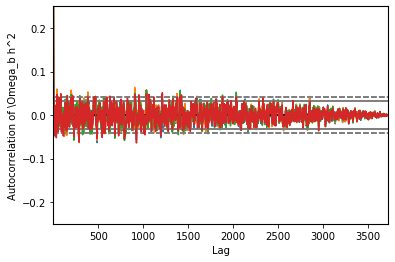

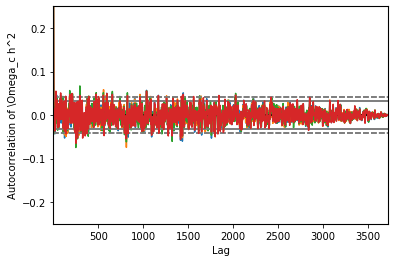

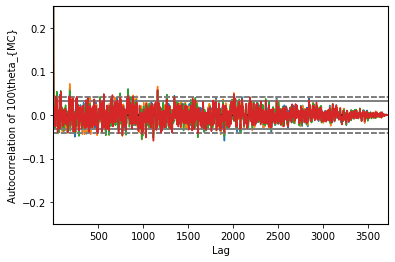

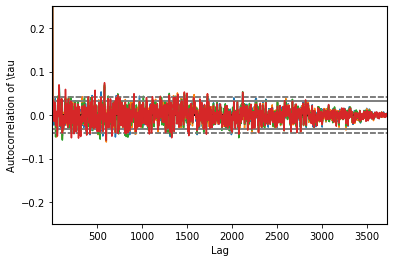

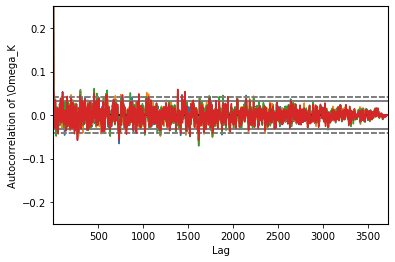

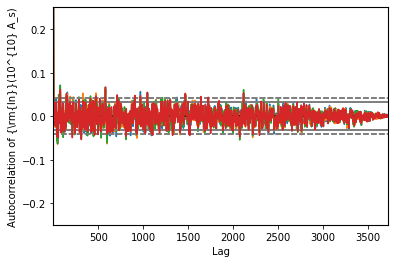

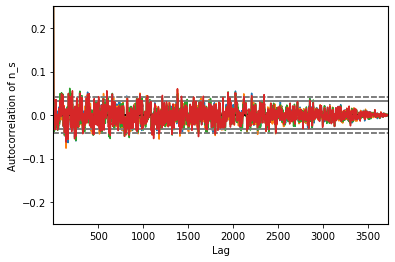

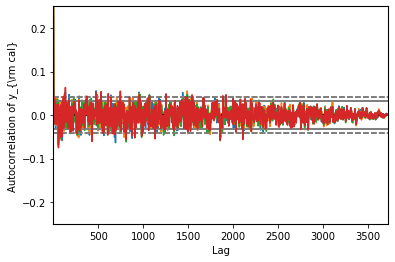

In [21]:
from pandas.plotting import autocorrelation_plot

for ind in range(8):
    plt.figure()
    for i in range(4):
        autocorrelation_plot(MCMC_samples[:, i, ind])
    plt.ylabel('Autocorrelation of %s' %(labels[ind]))
    plt.ylim(-0.25, 0.25)
    plt.show()


<span style="color:blue"> <i> 6. From the chain, obtain 1-d constraints on all 8 parameters. Print results. Also, show how far your MAP estimates are from the MCMC means ( Say (MAP estimate-MCMC mean)/MCMC standard deviation = 2. Then, your MAP estimate is 2 sigma away from the MCMC mean. )  </i></span><br>


In [22]:
for i in range(len(labels)):
    print("%s = %.5f +/- %.5f" %(labels[i], np.mean(MCMC_samples[:,:,i]), np.sqrt(np.var(MCMC_samples[:,:,i]))))

\Omega_b h^2 = 0.02255 +/- 0.00027
\Omega_c h^2 = 0.11729 +/- 0.00232
100\theta_{MC} = 1.04127 +/- 0.00051
\tau = 0.04833 +/- 0.00880
\Omega_K = -0.05698 +/- 0.02470
{\rm{ln}}(10^{10} A_s) = 3.02543 +/- 0.01840
n_s = 0.97212 +/- 0.00650
y_{\rm cal} = 1.00003 +/- 0.00252


In [23]:
for i in range(len(labels)):
    print("%s : MAP values %.2f sigma away from MCMC mean" %(labels[i], (x0_NCG[i] - np.mean(MCMC_samples[:,:,i])) / np.sqrt(np.var(MCMC_samples[:,:,i]))))
    

\Omega_b h^2 : MAP values -0.14 sigma away from MCMC mean
\Omega_c h^2 : MAP values 0.16 sigma away from MCMC mean
100\theta_{MC} : MAP values -0.13 sigma away from MCMC mean
\tau : MAP values 0.08 sigma away from MCMC mean
\Omega_K : MAP values 0.26 sigma away from MCMC mean
{\rm{ln}}(10^{10} A_s) : MAP values 0.12 sigma away from MCMC mean
n_s : MAP values -0.21 sigma away from MCMC mean
y_{\rm cal} : MAP values -0.03 sigma away from MCMC mean


We can now plot 1-d and 2-d constraints of our model parameters using "getdist" package:

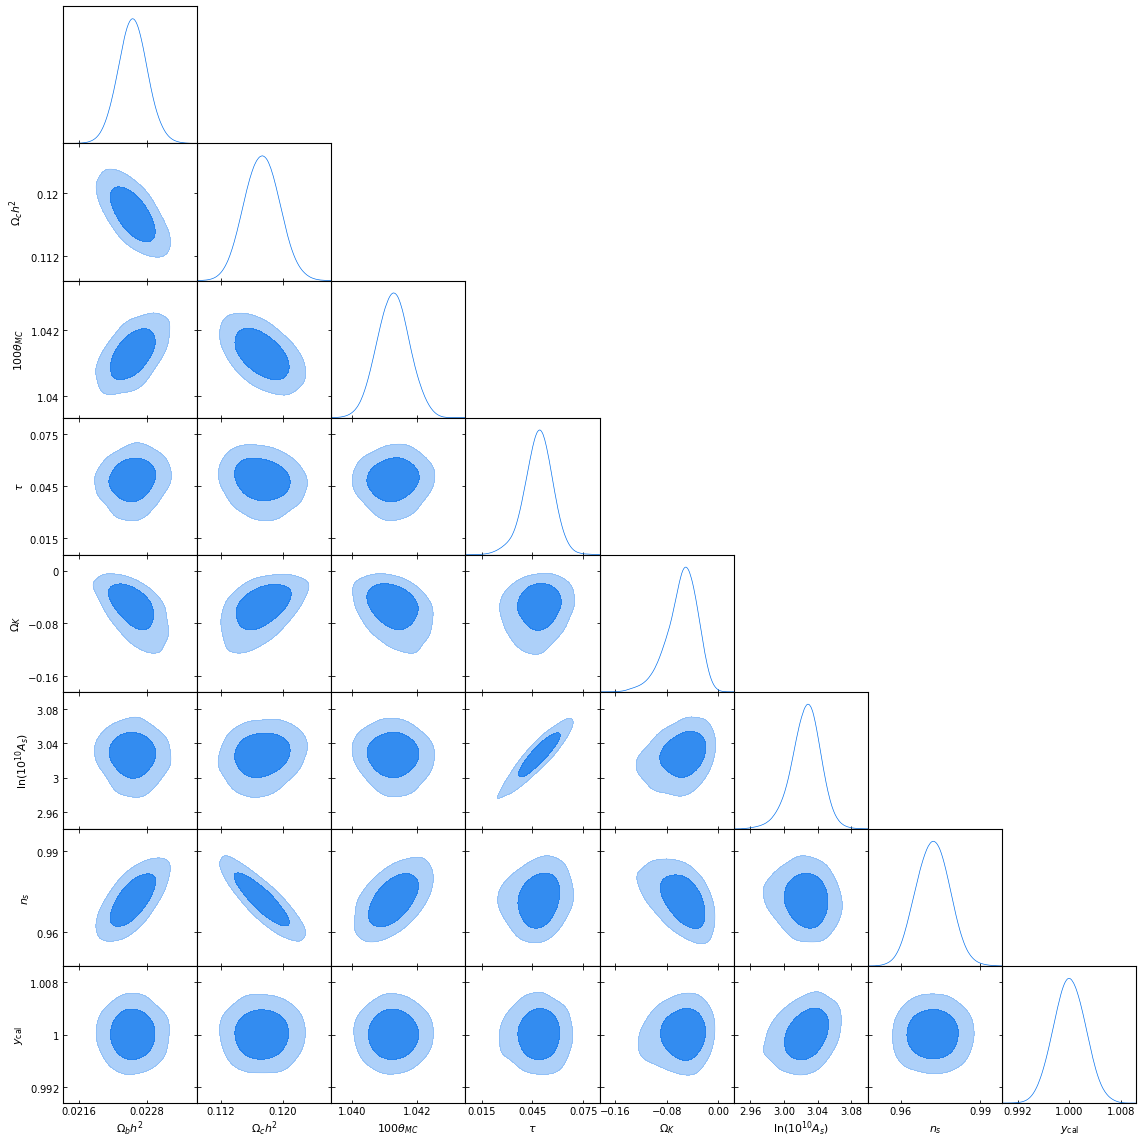

In [24]:
g = plots.getSubplotPlotter()
g.triangle_plot([MCMC], filled=True, contour_args={'alpha':0.8})

<span style="color:blue"> <i> 7. Back to MAP. Plot 1-d and 2-d constraints from MAP. For this task, we should first evaluate the hessian of -logp at our MAP estimates and convert it to covariance. (See Part 2 for hints) </i></span><br>

In [25]:
from scipy.linalg import inv 

Hess = Hessian(lambda xx: -quadmodel(xx), 1e-4)(x0_NCG)
cov = inv(Hess)
mean = x0_NCG

To plot MCMC and MAP results in a single figure, we should create samples from MAP. First, define a Gaussian distribution with mean and covariance defined above. Then, draw 5000 samples from it.

In [26]:
from getdist.gaussian_mixtures import GaussianND
GNd=GaussianND(mean, cov, label='MAP')
x_g = GNd.MCSamples(5000, names=names, labels=labels)
MAP = MCSamples(samples=x_g.samples, names=names, labels=labels)

Removed no burn in
Removed no burn in


<span style="color:blue"> <i> 8. Evaluate below cells to get results from MAP, MCMC, and bayesfast. </i></span><br>

Finally, we can compare MCMC and MAP results: MAP gets the peak of the posterior most of the time, but the Laplace approximation fails to give the full posterior shape.

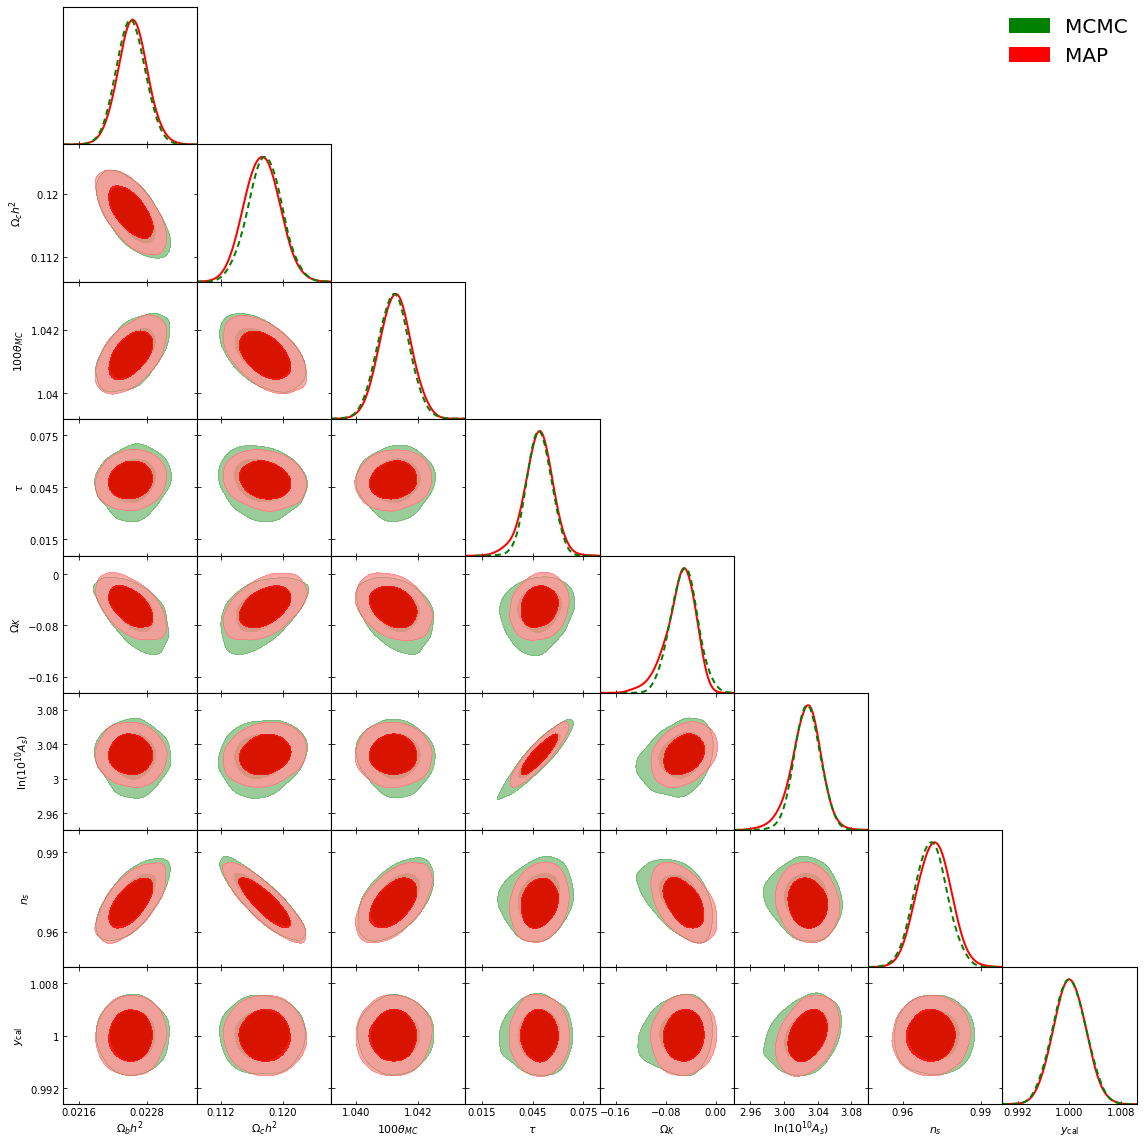

In [27]:
g = plots.getSubplotPlotter()
g.settings.figure_legend_frame = False
g.settings.legend_fontsize = 20
g.triangle_plot([MCMC,MAP], filled=True, 
                colors=['green', 'red', 'royalblue'], legend_labels=['MCMC', 'MAP'], 
                legend_loc='upper right', line_args=[{'lw':2, 'color':'red'}, {'ls':'--', 'lw':2, 'color':'green'}],
               )

We now use the method called "bayesfast" (developed by He and Seljak), which is a general fast Bayesian posterior method using the optimization-based posterior inference method called EL$_2$O (from Seljak and Yu, 2019).

In [28]:
from bayesfast.samplers.pymc3.nuts import NUTS
import bayesfast.utils.warnings as bfwarnings
import warnings

# Below is the temporary solution for printing the sampling progress
# We plan to rewrite it with e.g. tqdm in the future
warnings.showwarning = bfwarnings.showwarning_chain()
warnings.formatwarning = bfwarnings.formatwarning_chain()

Here, EL$_2$O is combined with quadratic surrogate HMC, and this allows a fast evaluation of the posterior. We start from our MAP estimates and draw 2500 HMC samples.

In [29]:
nuts = NUTS(max_treedepth=8, 
            logp_and_grad=(lambda xx: quadmodel.logp_and_grad(xx, False, False)),
            x_0=quadmodel.from_original(opt_NCG.x), 
            random_state=np.random.RandomState(0), 
            metric=None, step_size=1., target_accept=0.9)
sample_pre_transform = nuts.run(2500, 500)
sample_post_transform = quadmodel.to_original(np.array(sample_pre_transform.samples[501:]))
bayesfast = MCSamples(samples=sample_post_transform, names=names, labels=labels)

CHAIN #0: sampling proceeding [ 250 / 2500 ], last 250 samples used 24.52 seconds. (warmup)
CHAIN #0: sampling proceeding [ 500 / 2500 ], last 250 samples used 7.95 seconds. (warmup)
CHAIN #0: sampling proceeding [ 750 / 2500 ], last 250 samples used 7.42 seconds.
CHAIN #0: sampling proceeding [ 1000 / 2500 ], last 250 samples used 8.41 seconds.
CHAIN #0: sampling proceeding [ 1250 / 2500 ], last 250 samples used 7.76 seconds.
CHAIN #0: sampling proceeding [ 1500 / 2500 ], last 250 samples used 7.96 seconds.
CHAIN #0: sampling proceeding [ 1750 / 2500 ], last 250 samples used 7.83 seconds.
CHAIN #0: sampling proceeding [ 2000 / 2500 ], last 250 samples used 7.48 seconds.
CHAIN #0: sampling proceeding [ 2250 / 2500 ], last 250 samples used 8.06 seconds.
CHAIN #0: sampling finished   [ 2500 / 2500 ], obtained 2500 samples in 95.50 seconds.
Removed no burn in


You can see that the bayesfast posterior is almost equivalent to the MCMC posterior, and it succeeds in finding the non-Gaussian feature of the posterior.

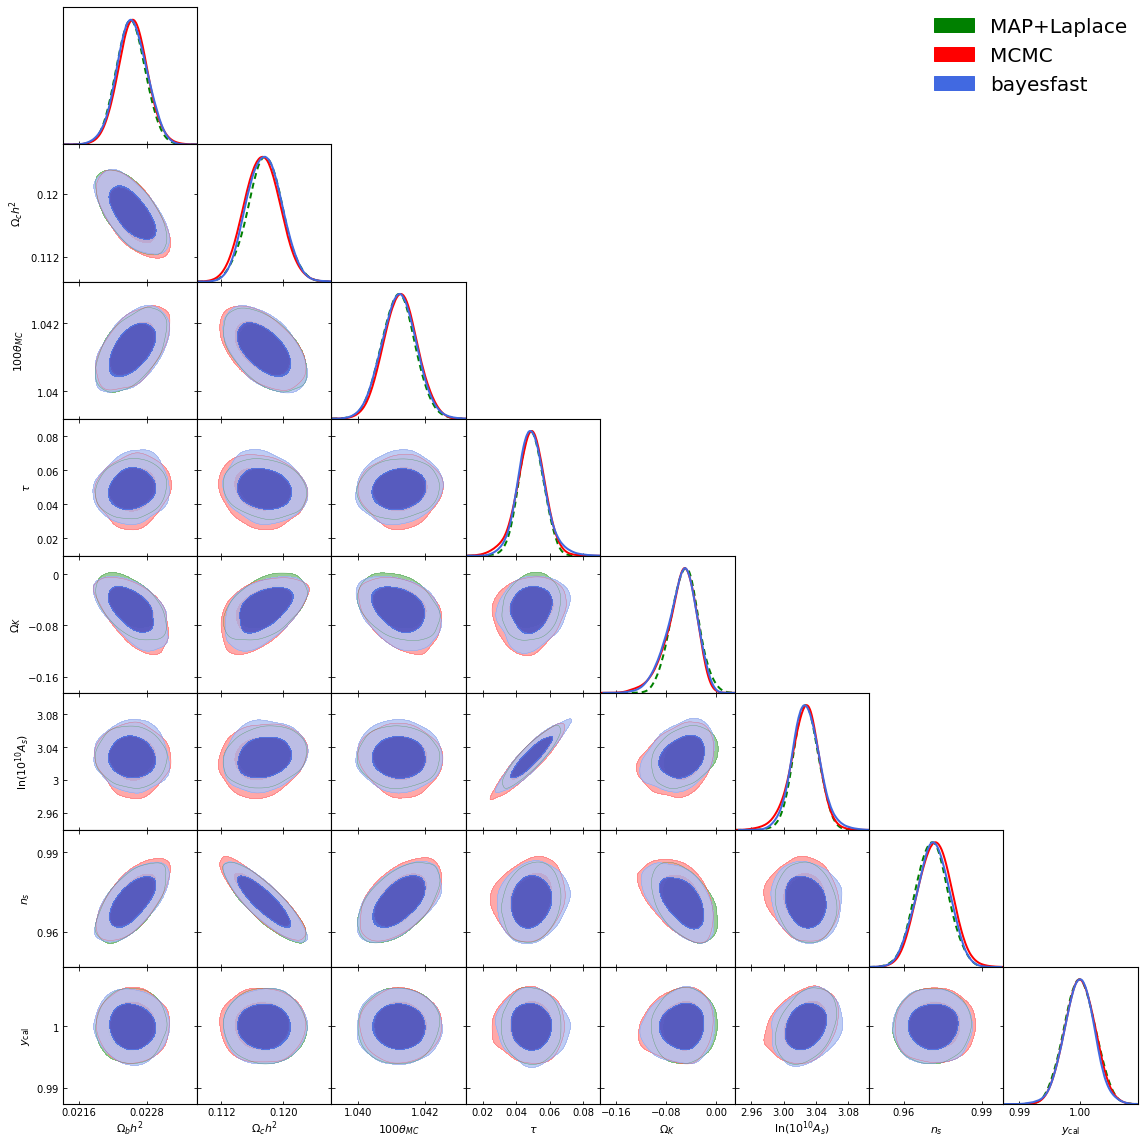

In [30]:
g = plots.getSubplotPlotter()
g.settings.figure_legend_frame = False
g.settings.legend_fontsize = 20
g.triangle_plot([MAP, MCMC, bayesfast], filled=True, 
                colors=['green', 'red', 'royalblue'], legend_labels=['MAP+Laplace', 'MCMC', 'bayesfast'], 
                legend_loc='upper right', line_args=[{'ls':'--', 'lw':2, 'color':'green'}, 
                                                     {'lw':2, 'color':'red'}, {'lw':2, 'color':'royalblue'}],
               )

***

#### Problem 2 - Supernova Cosmology Project

In this homework, we use a compilation of supernovae data to show that the expansion of the universe is accelerating, and hence it contains dark energy. This is the Nobel prize winning research in 2011 (https://www.nobelprize.org/nobel_prizes/physics/laureates/2011/), and Saul Perlmutter, a professor of physics at Berkeley, shared a prize in 2011 for this discovery.
<br><br>
"The expansion history of the universe can be determined quite easily, using as a “standard candle” any distinguishable class of astronomical objects of known intrinsic brightness that can be identified over a wide distance range. As the light from such beacons travels to Earth through an expanding universe, the cosmic expansion stretches not only the distances between galaxy clusters, but also the very wavelengths of the photons en route. By the time the light reaches us, the spectral wavelength $\lambda$ has thus been redshifted by precisely the same incremental factor $z = \Delta \lambda/\lambda$ by which the cosmos has been stretched in the time interval since the light left its source. The recorded redshift and brightness of each such object thus provide a measurement of the total integrated expansion of the universe since the time the light was emitted. A collection of such measurements, over a sufficient range of distances, would yield an entire historical record of the universe’s expansion." (Saul Perlmutter, http://supernova.lbl.gov/PhysicsTodayArticle.pdf).
<br><br>
Supernovae emerge as extremely promising candidates for measuring the cosmic expansion. Type I Supernovae arises from the collapse of white dwarf stars when the Chandrasekhar limit is reached. Such nuclear chain reaction occurs in the same way and at the same mass, the brightness of these supernovae are always the same. The relationship between the apparent brightness and distance of supernovae depend on the contents and curvature of the universe.
<br><br>
We can infer the "luminosity distance" $D_L$ from measuring the inferred brightness of a supernova of luminosity $L$. Assuming a naive Euclidean approach, if the supernova is observed to have flux $F$, then the area over which the flux is distributed is a sphere radius $D_L$, and hence <br><br>
$$F = \frac{L}{4\pi D_L^2}.$$
<br>
In Big Bang cosmology, $D_L$ is given by:
<br><br>
$$ D_L = \frac{\chi(a)}{a} $$
<br>
where $a$ is the scale factor ($\frac{\lambda_0}{\lambda} = 1 + z = \frac{a_0}{a}$, and the quantity with the subscript 0 means the value at present. Note that $a_0 = 1, z_0 = 0$.), and $\chi$ is the comoving distance, the distance between two objects as would be measured instantaneously today. For a photon, $cdt = a(t)d\chi$, so $\chi(t) = c\int_t^{t_0} \frac{dt'}{a(t')}$. We can write this in terms of a Hubble factor ($H(t) = \frac{1}{a}\frac{da}{dt}$), which tells you the expansion rate: $\chi(a) = c\int_a^1 \frac{da'}{a'^2H(a')} = c\int_0^z \frac{dz'}{H(z')}$. (change of variable using $a = \frac{1}{1+z}$.)
<br><br>
Using the Friedmann equation (which basically solves Einstein's equations for a homogenous and isotropic universe), we can write $H^2$ in terms of the mass density $\rho$ of the components in the universe: $H^2(z) = H_0^2[\Omega_m(1+z)^3 + (1-\Omega_m)(1+z)^2].$ <br><br>
$\Omega$ is the density parameter; it is the ratio of the observed density of matter and energy in the universe ($\rho$) to the critical density $\rho_c$ at which the universe would halt is expansion. So $\Omega_0$ (again, the subscript 0 means the value at the present) is the total mass and energy density of the universe today, and consequently $\Omega_0 = \Omega_{m}$ (matter density parameter today; remember we obtained the best-fit value of this parameter in Project 1?) = $\Omega_{\mathrm{baryonoic\ matter}}$ + $\Omega_{\mathrm{dark\ matter}}$. If $\Omega_0 < 1$, the universe will continue to expand forever. If $\Omega_0 > 1$, the expansion will stop eventually and the universe will start to recollapse. If $\Omega_0 = 1$, then the universe is flat and contains enough matter to halt the expansion but not enough to recollapse it. So it will continue expanding, but gradually slowing down all the time, finally running out of steam only in the infinite future. Even including dark matter in this calculation, cosmologists found that all the matters in the universe only amounts to about a quarter of the required critical mass, suggesting a continuously expanding universe with deceleration. Then, using all this, we can write the luminosity distance in terms of the density parameters: <br><br>
$$ D_L = \frac{\chi(a)}{a} = c(1+z)\int_0^z \frac{dz'}{H(z')} = c(1+z)\int_0^z \frac{dz'}{H_0[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^2]^{1/2}}  $$ <br>
$$ = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^2]^{1/2}}\ [unit\ of\ Mpc] $$
<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$.
<br><br>
Fluxes can be expressed in magnitudes $m$, where $m = -2.5\cdot\mathrm{log}_{10}F$ + const. The distance modulus is $\mu = m - M$ ($M$ is the absolute magnitude, the value of $m$ if the supernova is at a distance 10pc. Then, we have:
<br><br>
$$ \mu = 25 + 5\cdot \mathrm{log}_{10}\Big(D_L\ [in\ the\ unit\ of \ Mpc]\Big)$$
<br><br>
In this assignment, we use the SCP Union2.1 Supernova (SN) Ia compilation. (http://supernova.lbl.gov/union/)
<br><br>
First, load the measured data: $z$ (redshift), $\mu$ (distance modulus), $\sigma(\mu)$ (error on distance modulus)


In [31]:
data = np.loadtxt("sn_z_mu_dmu_plow_union2.1.txt", usecols=range(1,5))
# z
z_data = data[:,0]
# mu
mu_data = data[:,1]
# error on mu (sigma(mu))
mu_err_data = data[:,2]

<span style="color:blue"><i> 1. Plot the measured distance modulus as a function of redshift with errorbars. Then, assume three different scenarios: $\Omega_m = 0, 0.3, 1.$  </i></span> <br><br>
Remember:
$$ D_L = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^2]^{1/2}}$$ <br>
$$ \mu = 25 + 5\cdot \mathrm{log}_{10}(D_L)$$ <br><br>
<span style="color:blue"><i> Now, plot three curves of $\mu$ as a function of $z$ for $\Omega_m = 0, 0.3, 1$ on top of the measured data (Calculate $D_L$ using quad. For now, assume $h = 0.7$.) How do they fit? </i></span> <br>


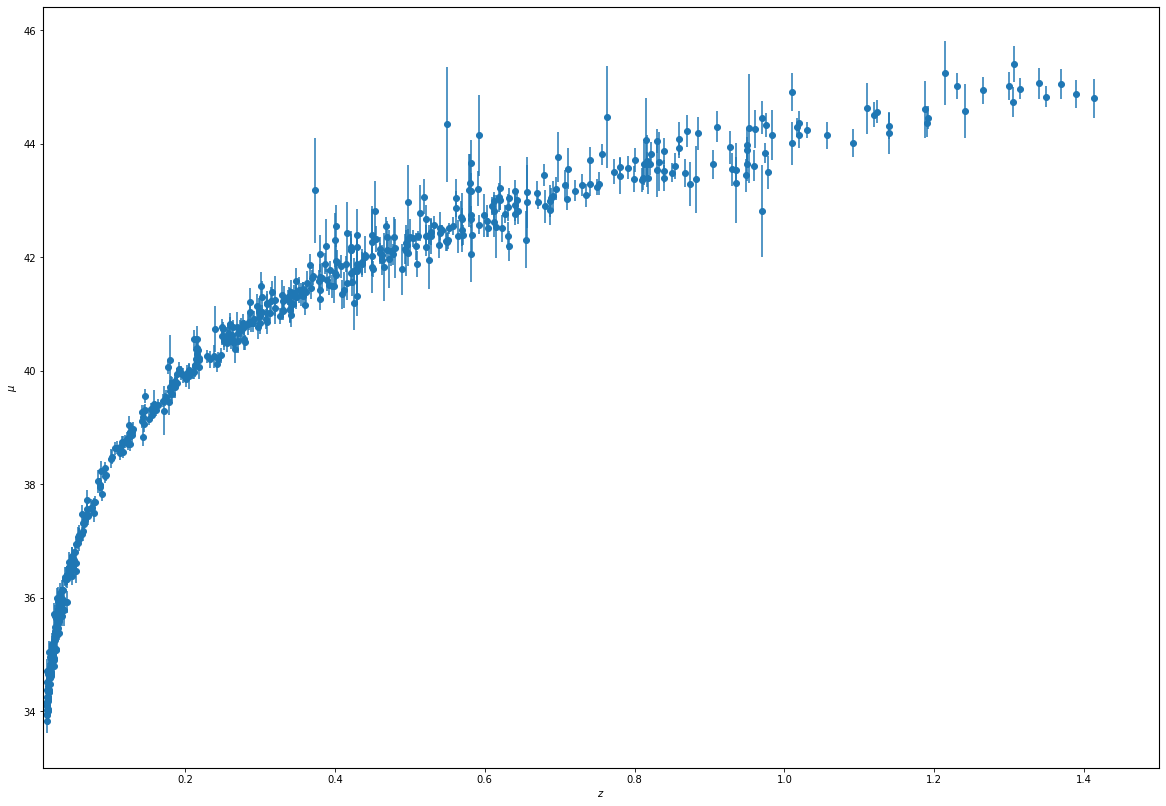

In [32]:
# Plotting.
plt.figure(figsize = (20,14))

plt.errorbar(z_data, mu_data, yerr = mu_err_data, linestyle = 'None', marker = 'o')

plt.xlim(0.01, 1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.show()

In [33]:
# Constants.
omega_ms = np.array([0.0, 0.3, 1.0])
h = 0.7

# Computes the mu at a given z for a given omega_m.
def mu(z, o_m):
    # The integral function for naive D_L.
    def integralFn(z_p, o):
        return 1.0 / np.sqrt(o_m * ((1 + z_p) ** 3) + (1 - o_m) * ((1 + z_p) ** 2))
    
    D_L = (2997.92458 / h) * (1 + z) * quad(integralFn, 0, z, args = (o_m,))[0]
    
    return 25 + 5.0 * np.log10(D_L)

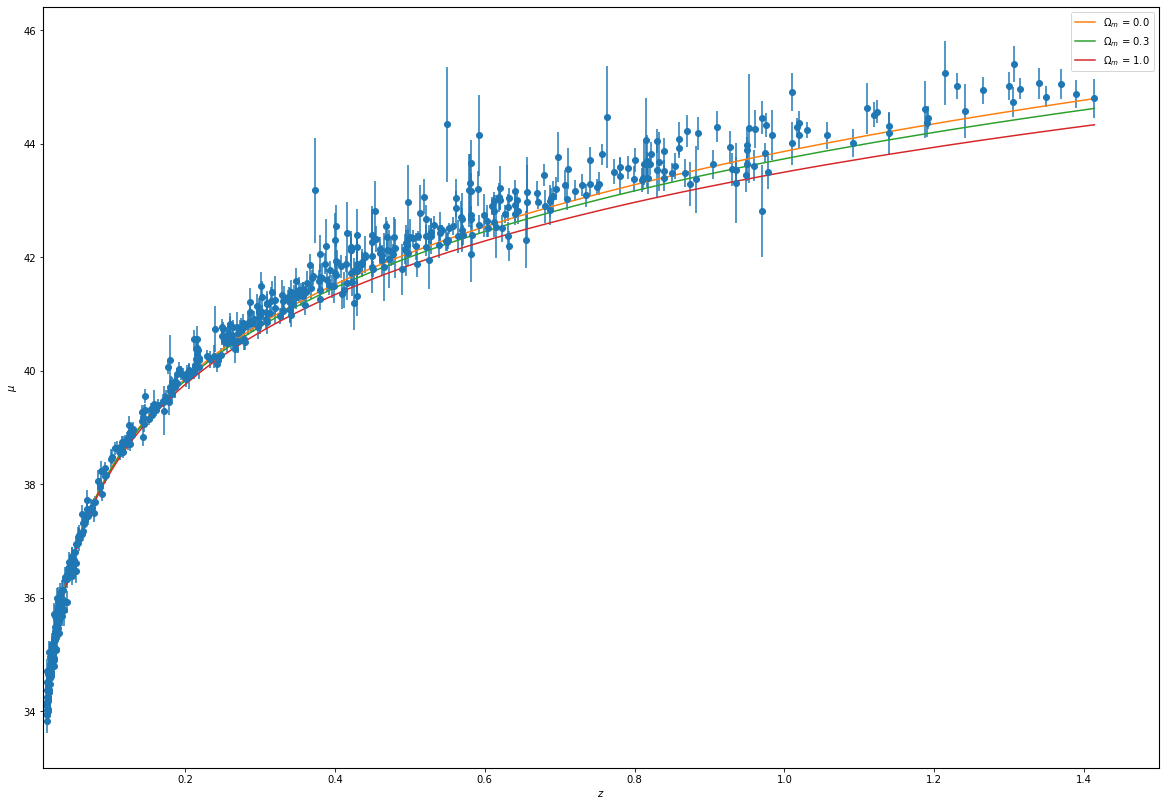

In [34]:
z_data_sorted = np.sort(z_data)        # Sorts data for plotting.

# Computes each model with respect to each omega_m value.
mu_models = np.zeros((omega_ms.size, z_data_sorted.size))
for i in range(omega_ms.size):
    for j in range(mu_models[i,:].size):
        mu_models[i, j] = mu(z_data_sorted[j], omega_ms[i])

# Plotting.
plt.figure(figsize = (20,14))

plt.errorbar(z_data, mu_data, yerr = mu_err_data, linestyle = 'None', marker = 'o')
for i in range(omega_ms.size):
    plt.plot(z_data_sorted, mu_models[i], label = "$\Omega_m$ = " + str(omega_ms[i]))

plt.legend()
plt.xlim(0.01, 1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.show()

You should find that the measured data do not fit well to all three scenarios. "The high-redshift supernovae are fainter than would be expected even for an empty cosmos (corresponding to $\Omega_m = 0$)." So what's wrong? 
<br><br>
"If these data are correct, the obvious implication is that the simplest cosmological model must be too simple. The next simplest model might be one that Einstein entertained for a time. Believing the universe to be static, he tentatively introduced into the equations of general relativity an expansionary term he called the “cosmological constant” ($\Lambda$) that would compete against gravitational collapse. After Hubble’s discovery of the cosmic expansion, Einstein famously rejected $\Lambda$ as his “greatest blunder.” In later years, $\Lambda$ came to be identified with the zero-point vacuum energy of all quantum fields. It turns out that invoking a cosmological constant allows us to fit the supernova data quite well." (Saul Perlmutter, https://www.nobelprize.org/nobel_prizes/physics/laureates/2011/)
<br><br>
So in short, the data indicates that faint supernovae are further away from the earth than had been theoretically expected. The expansion rate of the universe is increasing indeed. It seems that some mysterious material (which we call "dark energy") is causing such antigravity effects. The cosmological constant, $\Lambda$, the value of the energy density of the vacuum of space is widely accepted as a leading candidate of dark energy. 
<br><br>
Now let us add a general form of dark energy to our model.
<br><br>
$$H^2(z) = H_0^2[\Omega_m(1+z)^3 + \Omega_{DE}(1+z)^{3(1+w)} + (1-\Omega_m-\Omega_{DE})(1+z)^2].$$ <br> $w$ is the dark energy equation of state, which is the ratio of its pressure to its energy density. $w = -1$ for the cosmological constant $\Lambda$. <br><br>
$\Omega_0 = \Omega_{m}$ (matter density parameter today) + $\Omega_{DE}$ (dark energy density parameter today), and 
<br><br>
$$ D_L = \frac{\chi(a)}{a} = c(1+z)\int_0^z \frac{dz'}{H(z')} = c(1+z)\int_0^z \frac{dz'}{H_0[\Omega_m(1+z')^3 + \Omega_{DE}(1+z')^{3(1+w)} + (1-\Omega_m-\Omega_{DE})(1+z')^2]^{1/2}}  $$ <br>
$$ = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + \Omega_{DE}(1+z')^{3(1+w)} + (1-\Omega_m-\Omega_{DE})(1+z')^2]^{1/2}}\ [unit\ of\ Mpc] $$
<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$.

<span style="color:blue"> <i> 2. Now assume three different scenarios: ($\Omega_m = 0.3, \Omega_{DE} = 0$), ($\Omega_m = 0, \Omega_{DE} = 1, w = -1$), and ($\Omega_m = 0.3, \Omega_{DE} = 0.7, w = -1$). Again, plot three curves of $\mu$ as a function of $z$ on top of data (assume $h = 0.7$) </i></span><br>


In [35]:
# Each row is a case and each column is a parameter.
cases = np.array([[0.3, 0.0,  0.0],
                  [0.0, 1.0, -1.0],
                  [0.3, 0.7, -1.0]])

# Computes the mu at a given z for a given omega_m.
def mu(z, params):
    # The integral function for D_L.
    def integralFn(z_p, p):
        part1 = p[0] * ((1 + z_p) ** 3)
        part2 = p[1] * ((1 + z_p) ** (3 * (1 + p[2])))
        part3 = (1 - p[0] - p[1]) * ((1 + z_p) ** 2)
    
        return 1.0 / np.sqrt(part1 + part2 + part3)
    
    D_L = (2997.92458 / h) * (1 + z) * quad(integralFn, 0, z, args = (params,))[0]
    
    return 25.0 + 5.0 * np.log10(D_L)

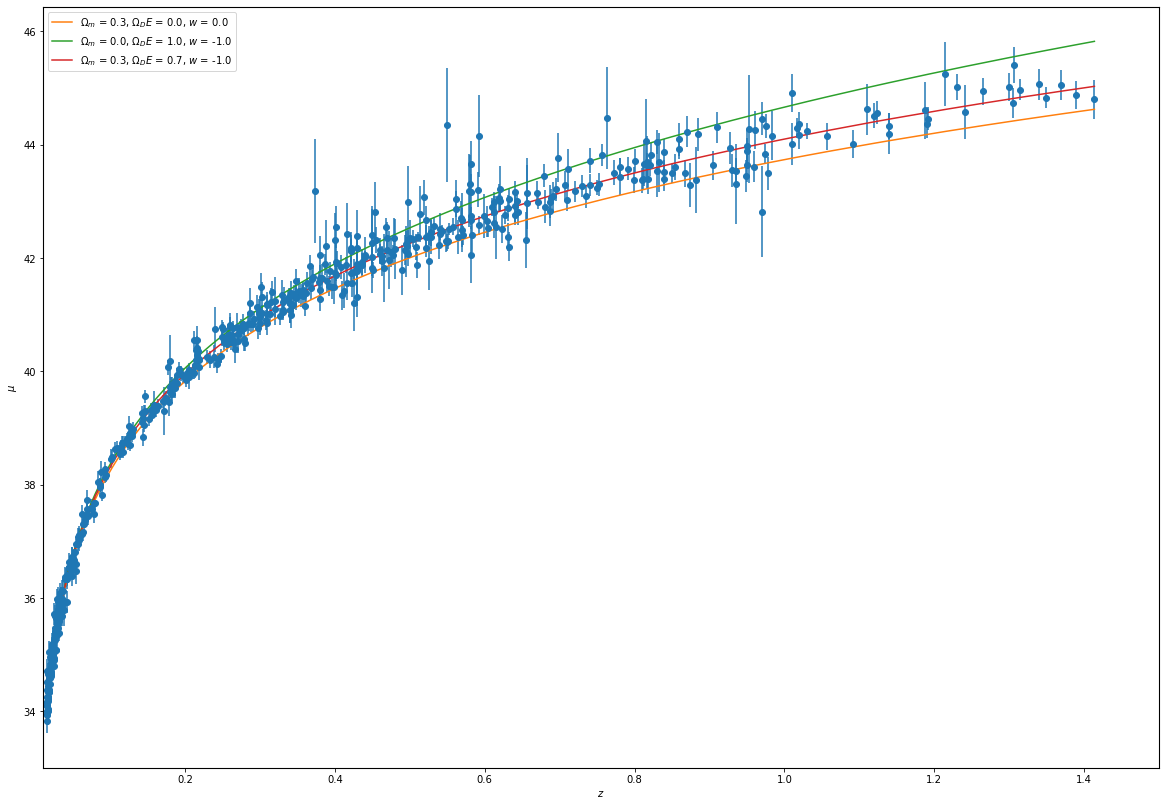

In [36]:
z_data_sorted = np.sort(z_data)        # Sorts data for plotting.

# Computes each model with respect to each case.
mu_models = np.zeros((3, z_data_sorted.size))
for i in range(3):
    for j in range(mu_models[i,:].size):
        mu_models[i, j] = mu(z_data_sorted[j], cases[i])

# Plotting.
plt.figure(figsize = (20,14))

plt.errorbar(z_data, mu_data, yerr = mu_err_data, linestyle = 'None', marker = 'o')
for i in range(3):
    model_name = "$\Omega_m$ = " + str(cases[i,0]) + ", $\Omega_DE$ = " + str(cases[i,1]) + ", $w$ = " + str(cases[i,2])
    plt.plot(z_data_sorted, mu_models[i], label = model_name)

plt.legend()
plt.xlim(0.01, 1.5)
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.show()

You basically reproduced the below figure!
![alt text](SN.png "Title")
You should see that $\Omega_m = 0.3$ and $\Omega_m = 0.7$ fits the data best. In combination with the CMB data, this shows that about 70% of the total energy density is vacuum energy and 30% is mass.
***
Now, with measurements of the distance modulus $\mu$, use Bayesian analysis to estimate the cosmological parameters.
<br><br>
let us assume that the universe is flat (which is a fair assumption since the CMB measurements indicate that the universe has no large-scale curvature). $\Omega_0 = \Omega_m + \Omega_{DE} = 1$. Then, we do not need to worry about the curvature term:<br><br>
$$ D_L = \frac{\chi(a)}{a} = c(1+z)\int_0^z \frac{dz'}{H(z')} = c(1+z)\int_0^z \frac{dz'}{H_0[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}}  $$ <br>
$$ = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}}\ [unit\ of\ Mpc] $$<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$.<br><br>
Assuming that errors are Gaussian (can be justified by averaging over large numbers of SN; central limit theorem), we calculate the likelihood $L$ as: <br><br>
$$ L \propto \mathrm{exp}\Big( -\frac{1}{2} \sum_{i = 1}^{N_{\mathrm{SN}}} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m, w)]^2}{\sigma(\mu_i)^2} \Big) $$
<br>
where $z_i, \mu_i, \sigma(\mu_i)$ are from the measurements, and we compute $\mu_{model}$ as a function of $z, \Omega_m, w$.

***

Next, write an MCMC code using the <b>Metropolis algorithm</b>. 

Now, assume a more general form of dark energy. (Do not fix $w$ to -1; add $w$ as a parameter.)

In the flat universe, <br><br>

$$ D_L = \frac{2997.92458}{h} (1+z)\int_0^z \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}}\ [unit\ of\ Mpc] $$
<br>
where $H_0 = 100\cdot h\ [km\cdot s^{-1} Mpc^{-1}]$. Here, we fix $h = 0.7$.<br><br>
We calculate the likelihood $L$ as: <br><br>
$$ \mathrm{ln}(L) \approx -\frac{1}{2} \sum_{i = 1}^{N_{\mathrm{SN}}} \frac{[\mu_{i,\ data}(z_i) - \mu_{i,\ model}(z_i, \Omega_m, w)]^2}{\sigma(\mu_i)^2} = -\frac{1}{2} \sum_{i = 1}^{N_{\mathrm{SN}}} \frac{\Delta \mu_i^2}{\sigma(\mu_i)^2} $$
<br>
where $$ \mu_{i,\ model}(z_i, \Omega_m, w) = 25 + 5\cdot \mathrm{log}_{10}(D_{L,\ i})$$<br>
$$ D_{L,\ i} = \frac{2997.92458}{0.7} (1+z_i)\int_0^{z_i} \frac{dz'}{[\Omega_m(1+z')^3 + (1-\Omega_m)(1+z')^{3(1+w)}]^{1/2}} $$
<br><br>
<span style="color:blue"> <i> 3. Run the MCMC code to estimate $w$ and $\Omega_m$. Plot 1-d posterior of $w$ and $\Omega_m$ as well as 2-d posterior (i.e. plot the chain in two-dimensional parameter space. Make sure that the chain has converged (you can change nsamples, nburn).  </i></span><br><br>

Hint:

Set the length of MCMC chains to be 15,000 (or even more if you think that the chain has not yet converged.) In the end, you should throw away the first 20% of the chain as burn-in. (20% is an arbitrary number. You can plot the chain and estimate the burn-in period.)

Then, set the random initial point in the parameter space $(w, \Omega_m)$: let $w$ be negative and $\Omega_m$ be positive and draw a random number using np.random.uniform(). Set initial likelihood to low value (e.g. -1.e100) so that next point is accepted.

Now, draw a new sample starting from this random initial point. Here we assume that the proposal distribution is Gaussian with arbitrary width: in this problem, we assume that $\sigma = 0.01$ (This determines how far you propose jumps.) for distributions for both $w, \Omega_m$.

For example, say that you start with $(w, \Omega_m)$ = $(-0.3, 0.7)$. Then, draw a new sample of $w$ from a Gaussian with $\mu = -0.3, \sigma = 0.01$ and a new sample of $\Omega_m$ from a Gaussian with $\mu = -0.7, \sigma = 0.01$.

Now, evaluate the log likelihood value of this new point.

If the value has gone up, accept the point.

Otherwise, accept it with probability given by ratio of likelihoods:
Draw a random number from a uniform distribution between 0 and 1 ( $\alpha$ = np.random.uniform() ). If the ratio $ln(\frac{L_{new}}{L_{old}})$ is greater than $ln(\alpha)$ (i.e. $\frac{L_{new}}{L_{old}} > \alpha$), then accept it. Otherwise, reject it and stay at your old point.

Repeat this 15,000 times (the length of chain) and plot the distributions of $(w, \Omega_m)$.

In [37]:
# Import data
data = np.loadtxt("sn_z_mu_dmu_plow_union2.1.txt", usecols=range(1,5))
# z
z_data = data[:,0]
# mu
mu_data = data[:,1]
# error on mu (sigma(mu))
mu_err_data = data[:,2]

# length of MCMC chains
nsamples = 30000
# number of parameters: Omega_m and w
npars    = 2

# Define (gaussian) width of the proposal distribution, one for each parameter. This determines how far you propose jumps
Sigma = [0.01, 0.01]

# Number of supernova:
nSN = len(z_data)

# Declare an empty array of the parameter values of each point. 
# Theta[:,0] stores a trace of the parameter \Omega_m  
# Theta[:,1] stores a trace of the parameter w 
# Theta[:,2] stores log-likelihood values at each point
Theta = np.empty([nsamples,npars+1])

# Dmu stores mu(data)-mu(theory), temporarily:
Dmu = np.empty(nSN)

# Random starting point in parameter space
# Set initial likelihood to low value so next point is accepted (could compute it instead):
Theta[0,:] = [-np.random.uniform(), np.random.uniform(), -1.0e100]

In [38]:
# Computes the mu at a given z for a given omega_m.
def mu(z, params):
    # The integral function for D_L.
    def integralFn(z_p, p):
        part1 = p[0] * ((1 + z_p) ** 3)
        part2 = (1 - p[0]) * ((1 + z_p) ** (3 * (1 + p[1])))
    
        return 1.0 / np.sqrt(part1 + part2)
    
    D_L = (2997.92458 / h) * (1 + z) * quad(integralFn, 0, z, args = (params,))[0]
    
    return 25.0 + 5.0 * np.log10(D_L)

In [39]:
# Define the likelihood function:
def lnL(Omegam, w):

    # Treat unphysical regions by setting likelihood to (almost) zero:    
    if(Omegam <= 0 or w >= 0):
        lnL = -1.0e100
    else:
        # Computes the difference of model mu with theory mu at redshifts of the SN, for trial Omegam
        for i in range(nSN):
            Dmu[i] = mu_data[i] - mu(z_data[i], np.array([Omegam, w]))

        # Compute ln(likelihood) assuming gaussian errors
        lnL = -0.5 * np.sum((Dmu ** 2) / (mu_err_data ** 2))
        
    return lnL

In [40]:
from math import floor

# Draw new proposed samples from a proposal distribution, centred on old values
# Accept or reject, and colour points according to ln(likelihood):

for i in range(1, nsamples):    
    
    # log likelihood value of previous point
    lnL_previous = Theta[i - 1,npars]
    
    # Draw a new sample around the previous point
    Omegam_new = np.random.normal(Theta[i - 1,1], Sigma[0])
    w_new = np.random.normal(Theta[i - 1,0], Sigma[1])
    # log likelihood value of current point    
    lnL_new = lnL(Omegam_new, w_new)

    # Metroplis-Hastings algorithm:

    if(lnL_new > lnL_previous):
    # Accept point if likelihood has gone up:
        Theta[i,:] = [w_new, Omegam_new, lnL_new]
        
    else:
    # Otherwise accept it with probability given by ratio of likelihoods:
        alpha = np.random.uniform()
    
        if(lnL_new - lnL_previous > np.log(alpha)):
        # Accept point if the likelihood ratio is greater than alpha:
            Theta[i,:] = [w_new, Omegam_new, lnL_new]
            
        else:
        # Reject; Repeat the previous point in the chain:
            Theta[i,:] = Theta[i - 1,:]

# Remove a burn in period, arbitrarily chosen to be the first 20% of the chain:
nburn = 2 * floor(nsamples / 10)

w =  -1.045935740179143 +/- 0.16154617124360743
Omega_m =  0.28825003302998886 +/- 0.06308067034704393


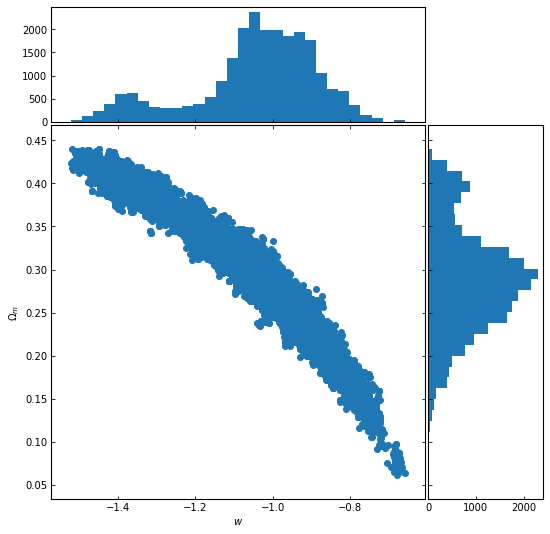

In [44]:
### INSPIRED BY: Scatter Plot With Histograms from Matplotlib.org ###
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# set the labels for the axes of the scatter plot
ax_scatter.set_xlabel("$w$")
ax_scatter.set_ylabel("$\Omega_m$")

# the scatter plot:
ax_scatter.scatter(Theta[nburn:,0], Theta[nburn:,1])

# the histograms:
ax_histx.hist(Theta[nburn:,0], bins=30)
ax_histy.hist(Theta[nburn:,1], bins=30, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()

# Print best-fit values and constraints
print ('w = ',np.mean(Theta[nburn:nsamples, 0]), '+/-' ,np.std(Theta[nburn:nsamples, 0]))
print ('Omega_m = ',np.mean(Theta[nburn:nsamples, 1]), '+/-' ,np.std(Theta[nburn:nsamples, 1]))

***

## To Submit
Execute the following cell to submit.
If you make changes, execute the cell again to resubmit the final copy of the notebook, they do not get updated automatically.<br>
__We recommend that all the above cells should be executed (their output visible) in the notebook at the time of submission.__ <br>
Only the final submission before the deadline will be graded. 


In [ ]:
_ = ok.submit()